Dataset shape: (5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Train class distribution: {np.int64(0): np.int64(3859), np.int64(1): np.int64(598)}
Test class distribution: {np.int64(0): np.int64(966), np.int64(1): np.int64(149)}

Decision stump train acc: 0.8828808615660758
Decision stump test acc: 0.895067264573991
Decision stump confusion matrix (test):
[[933  33]
 [ 84  65]]

A single decision stump is a very weak learner for high-dimensional text data.

Running manual AdaBoost (T=15)

Iteration 1
Misclassified train-local indices (first 50): [14, 49, 50, 59, 62, 67, 73, 86, 93, 96, 100, 115, 121, 157, 162, 173, 194, 196, 203, 224, 256, 276, 285, 298, 300, 302, 306, 327, 343, 344, 347, 351, 352, 359, 361, 362, 369, 370, 379, 389, 403, 404, 408, 417, 422, 430, 440, 456, 458, 460]
Weights of misclassified samples (first 50): [0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.000958, 0.00

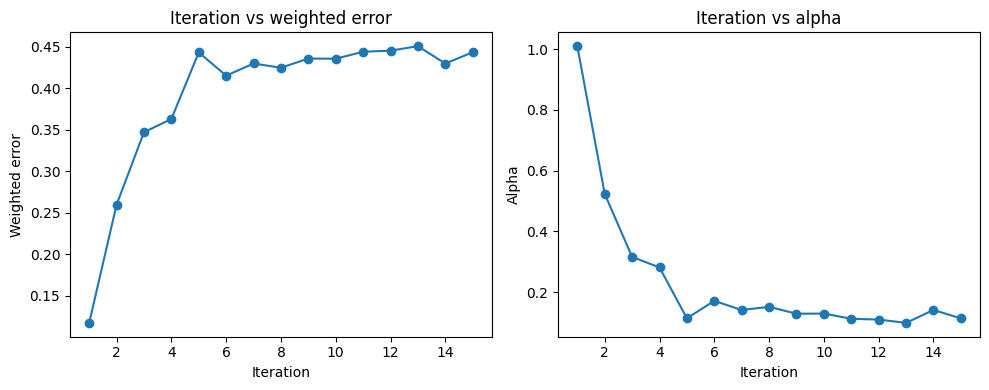


Short interpretation: weights increase for misclassified samples so future weak learners focus on them.


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Sklearn AdaBoost train acc: 0.913170293919677
Sklearn AdaBoost test acc: 0.9183856502242153
Sklearn AdaBoost confusion matrix (test):
[[964   2]
 [ 89  60]]

Top 10 TF-IDF features by importance:
txt 0.171451
claim 0.154099
call 0.115155
reply 0.100777
text 0.074473
mobile 0.06245
stop 0.05886
free 0.047235
win 0.042531
send 0.038736


In [3]:
# Q1 Part A
# Q1 Part B
# Q1 Part C
# Q1 Part D

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+',' ', s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    tokens = s.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)

csv_path = 'spam.csv'
if not os.path.exists(csv_path):
    try:
        url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
        df = pd.read_csv(url, sep='\t', header=None, names=['label','text'])
        df.to_csv(csv_path, index=False)
        print("Downloaded sample SMS dataset and saved as spam.csv")
    except Exception as e:
        print("Could not auto-download dataset. Please upload 'spam.csv' to Colab filesystem.")
        raise e
else:
    try:
        df = pd.read_csv(csv_path, encoding='latin-1', usecols=[0,1], names=['label','text'], header=0)
    except Exception:
        df_raw = pd.read_csv(csv_path, encoding='latin-1')
        txt_cols = [c for c in df_raw.columns if 'text' in c.lower() or 'message' in c.lower() or 'sms' in c.lower()]
        lbl_cols = [c for c in df_raw.columns if 'label' in c.lower() or 'class' in c.lower()]
        if txt_cols and lbl_cols:
            df = df_raw[[lbl_cols[0], txt_cols[0]]].rename(columns={lbl_cols[0]:'label', txt_cols[0]:'text'})
        else:
            df = df_raw.iloc[:, :2].copy()
            df.columns = ['label','text']

print("Dataset shape:", df.shape)
display(df.head())

df['label'] = df['label'].map(lambda x: 1 if str(x).strip().lower().startswith('spam') else 0)
df['text_clean'] = df['text'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text_clean']).toarray()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))
unique_t, counts_t = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique_t, counts_t)))

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)
print("\nDecision stump train acc:", accuracy_score(y_train, y_train_pred))
print("Decision stump test acc:", accuracy_score(y_test, y_test_pred))
print("Decision stump confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))
print("\nA single decision stump is a very weak learner for high-dimensional text data.")

def manual_adaboost(X_train, y_train, X_test, T=15):
    n = X_train.shape[0]
    w = np.ones(n) / n
    classifiers = []
    alphas = []
    weighted_errors = []
    for t in range(1, T+1):
        clf = DecisionTreeClassifier(max_depth=1, random_state=42)
        clf.fit(X_train, y_train, sample_weight=w)
        pred = clf.predict(X_train)
        incorrect = (pred != y_train).astype(int)
        eps = np.sum(w * incorrect) / np.sum(w)
        eps = np.clip(eps, 1e-12, 1-1e-12)
        alpha = 0.5 * np.log((1 - eps) / eps)
        w = w * np.exp(alpha * (incorrect * 2 - 1))
        w = w / np.sum(w)
        classifiers.append(clf)
        alphas.append(alpha)
        weighted_errors.append(eps)
        mis_idx = np.where(incorrect==1)[0]
        print(f"\nIteration {t}")
        if len(mis_idx) > 0:
            print("Misclassified train-local indices (first 50):", mis_idx.tolist()[:50])
            print("Weights of misclassified samples (first 50):", np.round(w[mis_idx][:50], 6).tolist())
        else:
            print("No misclassifications on training set.")
        print("Alpha:", float(alpha))
    return {
        'classifiers': classifiers,
        'alphas': alphas,
        'weighted_errors': weighted_errors
    }

print("\nRunning manual AdaBoost (T=15)")
manual_res = manual_adaboost(X_train, y_train, X_test, T=15)

def ensemble_predict(X, classifiers, alphas):
    agg = None
    for clf, alpha in zip(classifiers, alphas):
        p = clf.predict(X)
        val = alpha * (2*p - 1)
        if agg is None:
            agg = val
        else:
            agg = agg + val
    preds = (np.sign(agg) + 1) // 2
    return preds

y_train_ens = ensemble_predict(X_train, manual_res['classifiers'], manual_res['alphas'])
y_test_ens = ensemble_predict(X_test, manual_res['classifiers'], manual_res['alphas'])

print("\nManual AdaBoost train acc:", accuracy_score(y_train, y_train_ens))
print("Manual AdaBoost test acc:", accuracy_score(y_test, y_test_ens))
print("Manual AdaBoost confusion matrix (test):")
print(confusion_matrix(y_test, y_test_ens))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1,len(manual_res['weighted_errors'])+1), manual_res['weighted_errors'], marker='o')
plt.xlabel('Iteration'); plt.ylabel('Weighted error'); plt.title('Iteration vs weighted error')
plt.subplot(1,2,2)
plt.plot(range(1,len(manual_res['alphas'])+1), manual_res['alphas'], marker='o')
plt.xlabel('Iteration'); plt.ylabel('Alpha'); plt.title('Iteration vs alpha')
plt.tight_layout()
plt.show()

print("\nShort interpretation: weights increase for misclassified samples so future weak learners focus on them.")

sk_adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    algorithm='SAMME',
    random_state=42
)
sk_adaboost.fit(X_train, y_train)
y_train_sk = sk_adaboost.predict(X_train)
y_test_sk = sk_adaboost.predict(X_test)

print("\nSklearn AdaBoost train acc:", accuracy_score(y_train, y_train_sk))
print("Sklearn AdaBoost test acc:", accuracy_score(y_test, y_test_sk))
print("Sklearn AdaBoost confusion matrix (test):")
print(confusion_matrix(y_test, y_test_sk))

if hasattr(sk_adaboost, 'feature_importances_'):
    fi = sk_adaboost.feature_importances_
    top_idx = np.argsort(fi)[-10:][::-1]
    print("\nTop 10 TF-IDF features by importance:")
    for i in top_idx:
        name = tfidf.get_feature_names_out()[i] if hasattr(tfidf, 'get_feature_names_out') else f"f{i}"
        print(name, round(fi[i],6))